# Delta Flight 89: Historic flight path data

### Load Python tools

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import jenkspy
import numpy as np
import glob
import io
import os
from shapely.geometry import Point, LineString
from altair import datum
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

### We have 313 CSVs for each flight over a year. What does one look like?

In [2]:
a_flight = pd.read_csv('input/flights/DL89_228f611c.csv')
a_flight.head()

,Timestamp,UTC,Callsign,Position,Altitude,Speed,Direction
0,1571684146,2019-10-21T18:55:46Z,DAL89,"33.945415,-118.410347",0,0,264
1,1571688008,2019-10-21T20:00:08Z,DAL89,"33.945431,-118.410126",0,9,264
2,1571688026,2019-10-21T20:00:26Z,DAL89,"33.945442,-118.409904",0,9,258
3,1571688044,2019-10-21T20:00:44Z,DAL89,"33.945438,-118.40966",0,9,250
4,1571688065,2019-10-21T20:01:05Z,DAL89,"33.945442,-118.409454",0,2,236


In [3]:
a_flight.dtypes

Timestamp     int64
UTC          object
Callsign     object
Position     object
Altitude      int64
Speed         int64
Direction     int64
dtype: object

### Concatenate the flight path files

In [4]:
#set path
path = 'input/flights/'

In [5]:
files = glob.glob(os.path.join(path, "*.csv"))

### Read the csv and create a 'flightid' field so we can track unique flights

In [6]:
file_df = (pd.read_csv(f, encoding = "ISO-8859-1", low_memory=False)\
           .assign(flightid=os.path.basename(f)) for f in files)

In [7]:
concatenated_df = pd.concat(file_df, ignore_index=True)

In [8]:
concatenated_df['flightid'] = concatenated_df['flightid']\
    .str.replace('DL89_','')\
    .str.replace('.csv','')

### How many flight segments do we have? 

In [9]:
len(concatenated_df)

196276

### Clean up the dataframe

In [10]:
concatenated_df.columns = concatenated_df.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [11]:
flights = pd.DataFrame(concatenated_df.sort_values(by='timestamp', ascending=False))
flights.head()

,timestamp,utc,callsign,position,altitude,speed,direction,flightid
100664,1579032628,2020-01-14T20:10:28Z,DAL89,"33.947285,-118.404953",0,12,132,23856f50
100663,1579032616,2020-01-14T20:10:16Z,DAL89,"33.947453,-118.405182",0,15,132,23856f50
100662,1579032605,2020-01-14T20:10:05Z,DAL89,"33.947697,-118.405479",0,19,118,23856f50
100661,1579032598,2020-01-14T20:09:58Z,DAL89,"33.947823,-118.405685",0,20,101,23856f50
100660,1579032592,2020-01-14T20:09:52Z,DAL89,"33.947857,-118.405907",0,21,84,23856f50


### Split location field into lat, lon to create a geodataframe

In [12]:
lat = []
lon = []

for row in flights['position']:
    lat.append(row.split(',')[0])
    lon.append(row.split(',')[1])
        
flights['latitude'] = lat
flights['longitude'] = lon

In [13]:
flights['latitude'] = flights['latitude'].astype(float)
flights['longitude'] = flights['longitude'].astype(float)

### Convert the UTC date string into an actual datetime series

In [14]:
flights['utc_datetime'] = pd.to_datetime(flights['utc'], format='%Y-%m-%dT%H:%M:%SZ').dt.tz_localize('UTC')

### Localize to Los Angeles time

In [15]:
flights['datetime'] = flights['utc_datetime'].dt.tz_convert('America/Los_Angeles')

### In case we need simploer date/time fields

In [16]:
flights['date'] = pd.to_datetime(flights['datetime']).dt.strftime('%m/%d/%Y')
flights['time'] = pd.to_datetime(flights['datetime']).dt.strftime('%H:%M:%S')
flights['display_time'] = pd.to_datetime(flights['datetime']).dt.strftime('%I:%M %p')
flights['weekday'] = flights['datetime'].dt.weekday_name

### Lighten the dataframe a bit

In [17]:
flights = flights.drop(['utc', 'timestamp','position','utc_datetime'], axis=1)

In [18]:
flights.head()

,callsign,altitude,speed,direction,flightid,latitude,longitude,datetime,date,time,display_time,weekday
100664,DAL89,0,12,132,23856f50,33.947285,-118.404953,2020-01-14 12:10:28-08:00,01/14/2020,12:10:28,12:10 PM,Tuesday
100663,DAL89,0,15,132,23856f50,33.947453,-118.405182,2020-01-14 12:10:16-08:00,01/14/2020,12:10:16,12:10 PM,Tuesday
100662,DAL89,0,19,118,23856f50,33.947697,-118.405479,2020-01-14 12:10:05-08:00,01/14/2020,12:10:05,12:10 PM,Tuesday
100661,DAL89,0,20,101,23856f50,33.947823,-118.405685,2020-01-14 12:09:58-08:00,01/14/2020,12:09:58,12:09 PM,Tuesday
100660,DAL89,0,21,84,23856f50,33.947857,-118.405907,2020-01-14 12:09:52-08:00,01/14/2020,12:09:52,12:09 PM,Tuesday


### Export the dataframe as a CSV

In [19]:
flights.to_csv('output/flights.csv')

---

## Geography

### Let's convert our flights data to a geodataframe

In [20]:
flights_geo = gpd.GeoDataFrame(flights, geometry=gpd.points_from_xy(flights['longitude'], flights['latitude']))

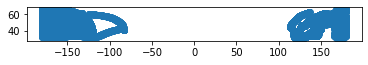

In [21]:
flights_geo.plot()

### We're going to need to clip the flights to a SoCal extent

In [22]:
california = gpd.read_file('input/calif.geojson')
cali_gdf = gpd.GeoDataFrame(california)

### Add a dummy buffer around the state so we don't clip flights over the ocean south of Malibu

In [23]:
cali_gdf['geometry'] = cali_gdf['geometry'].buffer(3)

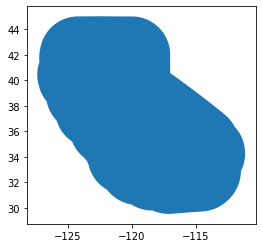

In [24]:
# so janky
cali_gdf.plot()

### Clip the flight points to Cali because hemispheres are hard

In [25]:
clipped_points = gpd.sjoin(flights_geo, cali_gdf, op='intersects')

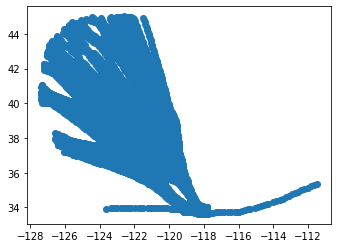

In [26]:
clipped_points.plot()

### We need flight paths. Convert to points to linestring

In [27]:
flights_geo_line = clipped_points.groupby('flightid')['geometry']\
    .apply(lambda x: LineString(x.tolist()) if x.size > 1 else x.tolist())

In [28]:
flights_geo_line = gpd.GeoDataFrame(flights_geo_line, geometry='geometry').reset_index()

In [29]:
flights_geo_line.head()

,flightid,geometry
0,1f2e4d5f,"LINESTRING (-126.741287 43.15538, -126.607147 ..."
1,1f337e97,"LINESTRING (-126.676483 43.472492, -126.599449..."
2,1f366087,"LINESTRING (-122.375267 44.910782, -122.340744..."
3,1f39007e,"LINESTRING (-126.857216 43.252899, -126.738083..."
4,1f3dcc94,"LINESTRING (-122.871422 44.918976, -122.804375..."


### Remove anomalous flights

In [30]:
flights_geo_line = flights_geo_line.drop([31, 231])

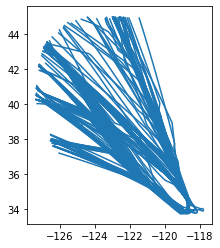

In [31]:
flights_geo_line.plot()

In [32]:
flights_geo.to_file('output/flights_geo.geojson', driver='GeoJSON')

In [33]:
flights_geo_line.to_file('output/flights_geo_line.geojson', driver='GeoJSON')

In [35]:
flights_geo_delta = flights_geo_line[flights_geo['flightid'] == '23856f50']

//anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:471: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


In [ ]:
flights_geo_line_delta = flights_geo_line_cali[flights_geo_line['flightid'] == '23856f50']

In [ ]:
flights_geo_line_delta.to_file('output/flights_geo_line_delta.geojson', driver='GeoJSON')

In [ ]:
flights_geo_line_delta.plot()

In [ ]:
flights_geo_delta.to_file('output/flights_geo_delta.geojson', driver='GeoJSON')

In [ ]:
delta_89_gas_flight.to_csv('output/delta_89_gas_flight.csv')

In [ ]:
delta_89_gas_flight.to_file('output/delta_89_gas_flight.geojson', driver='GeoJSON')